In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Cat vs. Dog Clasificación de Imágenes
## Ejercicio 3: Extracción de características y fine-tuning
**_Tiempo estimado: 30 minutos_**

En el ejercicio 1 diseñamos nuestra CNN desde 0, y conseguimos un accuracy cercano al 70%. Tras añadir dropout y data augmentation en el ejercicio 2 llegamos al 80%. No esta mal, pero 20% es todavía una tasa de error demasiado alta. Quizá no tenemos suficientes datos de entrenamiento... ¿Qué podríamos hacer?

En ese ejercicio, vamos a investigar dos técnicas que podemos aplicar en este y otros muchos casos. Concretamente, vamos a investigar **feature extraction** y **fine tuning**, técnicas que nos van a permitir aprovecharnos de modelos muy potentes que han sido entrenados con muchísimos datos.

## Extracción de Características mediante Modelos Preentrenados

Una técnica que es muy común cuando trabajamos con imágenes es utilizar modelos entrenados en datasets muy grandes, correr nuestro dataset a través de ellos, y extraer las representaciones intermedias (features) que el modelo genera. Debido a que las imágenes tienen mucho en común a pesar de que estos modelos no estén entrenados exáctamente para nuestro problema, esto nos permite extraer características que seguramente sean muy informativas para nuestra tarea a resolver. Esta versatilidad y capacidad de repropósito de las CNNs es uno de los aspectos más interesantes, no sólo de las CNNs, si no del mundo del Deep Learning.

En nuestro caso, vamos a utilizar el modelo [Inception V3](https://arxiv.org/abs/1512.00567) desarrollado en Google y pre-entrenado en [ImageNet](http://image-net.org/), una base de datos de 1.4M de imágenes y 1000 clases. Es un modelo muy potente, vamos a ver qué características aprendidas pueden ayudarnos en nuestro problema.

Primero, tenemos que elegir qué representación intermedia (qué capa) del Inception V3 vamos a utilizar para nuestra extracción de características. Lo más común es usar la salida de la última capa convolucional antes de la operación `Flatten`, a veces conocida como "bottleneck layer." El razonamiento es que las capas fully connected van a estar muy especializadas para la tarea en concreto a resolver, sin embargo, la capa bottleneck debería tener una extracción de características muy potente y más extrapolable a cualquier otra tarea que trabaje con imágenes.

Ahora vamos a instanciar nuestro modelo Inception V3 con los pesos ya entrenados para enfrentarse a ImageNet:

In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Descargamos los pesos:

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-11-05 14:09:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  27.1MB/s    in 3.1s    

2021-11-05 14:09:30 (27.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

Al especificar `include_top=False`, cargamos una red que no incluye las capas de clasificación finales (como hemos comentado anteriormente).

Como no queremos modificar este modelo, vamos a configurarlo como "no entrenable", así sólo entrenaremos las capas que nosotros añadamos a posteriori.

In [5]:
for layer in pre_trained_model.layers:
  layer.trainable = False

La capa que vamos a utilizar para la extracción de características en Inception V3 se llama `mixed7`. No es exáctamente la capa bottleneck de la red, pero la vamos a utilizar para extraer un feature map lo bastante grande (7x7 en nuestro caso). Si hubiésemos usado la capa bottleneck habríamos acabado con un feature map de 3x3, que es quizá demasiado pequeño:

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Ahora vamos a añadir nuestra capa fully connected a continuación de `last_output`:

In [7]:
from tensorflow.keras.optimizers import RMSprop

# Capa flatten para vectorizar nuestro feature map
x = layers.Flatten()(last_output)
# Añadimos una fully connected con 1024 neuronas y función de activación ReLU.
x = layers.Dense(1024, activation='relu')(x)
# Añadimos un Dropout del 0.2
x = layers.Dropout(0.2)(x)
# Añadimos nuestra capa de salida
x = layers.Dense(1, activation='sigmoid')(x)

# Configuramos y compilamos el modelo
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Para los datos y el preprocesado vamos a utilizar nuestro código del Ejercicio 2.

**NOTA:** Las 2.000 imagenes utilizadas en este ejercicio se han extraído de la base de datos ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) disponible en Kaggle, la cual contiene 25.000 imágenes. Nosotros vamos a utilizar un subset para agilizar el aprendizaje.

In [8]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2021-11-05 14:09:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  41.0MB/s    in 1.6s    

2021-11-05 14:09:40 (41.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio con nuestras imágenes de train de gatos
train_cats_dir = os.path.join(train_dir, 'cats')

# Directorio con nuestras imágenes de train de perros
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con nuestras imágenes de validación de gatos
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directorio con nuestras imágenes de validación de perros
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Estas son las transformaciones que vamos a realizar: 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# IMPORTANTE! No tenemos que augmentar los datos de validación!
val_datagen = ImageDataGenerator(rescale=1./255)

# Producimos imágenes en batches de 20 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # directorio fuente
        target_size=(150, 150),  # Las imágenes se van a reescalar a tamaño 150x150
        batch_size=20,
        # Como utilizamos la función de coste binary_crossentropy loss, necesitamos etiquetas binarias
        class_mode='binary')

# Por último, preparamos los datos de validación
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Finalmente, vamos a entrenar el modelo con estas características. Vamos a utilizar las 2000 imágenes de train, 2 épocas y 1000 imágenes de valid.

In [10]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/10
100/100 - 56s - loss: 0.3597 - acc: 0.8590 - val_loss: 0.1082 - val_acc: 0.9570
Epoch 2/10
100/100 - 21s - loss: 0.2055 - acc: 0.9165 - val_loss: 0.0808 - val_acc: 0.9710
Epoch 3/10
100/100 - 22s - loss: 0.2109 - acc: 0.9205 - val_loss: 0.1083 - val_acc: 0.9600
Epoch 4/10
100/100 - 22s - loss: 0.1876 - acc: 0.9270 - val_loss: 0.0980 - val_acc: 0.9670
Epoch 5/10
100/100 - 21s - loss: 0.2036 - acc: 0.9320 - val_loss: 0.0946 - val_acc: 0.9670
Epoch 6/10
100/100 - 21s - loss: 0.1753 - acc: 0.9330 - val_loss: 0.1194 - val_acc: 0.9660
Epoch 7/10
100/100 - 21s - loss: 0.1882 - acc: 0.9380 - val_loss: 0.1038 - val_acc: 0.9640
Epoch 8/10
100/100 - 21s - loss: 0.1653 - acc: 0.9390 - val_loss: 0.1360 - val_acc: 0.9610
Epoch 9/10
100/100 - 22s - loss: 0.1512 - acc: 0.9480 - val_loss: 0.1781 - val_acc: 0.9470
Epoch 10/10
100/100 - 21s - loss: 0.1620 - acc: 0.9465 - val_loss: 0.1359 - val_acc: 0.9660


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Como puedes ver ahora alcanzamos un accuracy del 88–90% muy rapidamente. Tenemos la potencia de los mejores clasificadores de Google trabajando para nosotros!

## Mejorando aún más el rendimiento mediante Fine-Tuning

En nuestro experimento anterior hemos añadido dos capas Dense a continuación del modelo preentrenado Inceptión V3. Sin embargo, los pesos de la red preentrenada no se han modificado durante el entrenamiento. Una forma de mejorar aún más el rendimiento sería ajustar (fine-tine) los pesos de las capas superiores de nuestro modelo preentrenado además de nuestras capas Dense del final. Os dejo un par de notas sobre el fine-tuning:

- **Fine-tuning sólo debe llevarse a cabo *después* de haber entrenado las capas finales con el modelo preentrenado con el parámetro non-trainable**. Si añades capas aleatorias al clasificador e intentas entrenar el modelo completo, la magnitud del gradiente va a ser demasiado grande (debido a que las capas finales comienzan con pesos aleatorios) y tu modelo preentrenado va a olvidar todo lo que había aprendido con el equipo de Google ;)
- Adicionalmente, hacemos fine-tune **sólo sobre las capas superiores del modelo pre-entrenado** en lugar de hacerlo sobre todo el modelo, ya que, en nuestra CNN, las capas superiores son las más especializadas. Las primeras capas en una CNN están extrayendo información simple y genérica de nuestras imágenes. Este tipo de información debería generalizar a todo tipo de tarea, sin embargo, las últimas capas podrían empezar a contener información más específica a la tarea. Recuerda que con fine-tuning no pretendemos mejorar las redes ya entrenadas, sólo queremos ajustarlas a nuestra tarea.

Todo lo que tenemos que hacer para implementar fine-tuning es declarar las capas superiores de Inception V3 como *trainable*, recompilar el modelo (necesario para que los cambios tengan efecto) y continuar nuestro entrenamiento.

Vamos a descongelar todas las capas pertenecientes al módulo `mixed7`y a recompilar nuestro modelo!

In [12]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Descongelamos todas las capas posteriores a "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# Como optimizador vamos a utilizar SGD
# con un learning rate muy pequeño (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Ahora vamos a reentrenar nuestro modelo. Entrenaremos con 2000 imágenes de entrenamiento, durante 50 épocas, y validaremos con nuestras 1000 imágenes de validación.

In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 29s - loss: 0.2170 - acc: 0.9105 - val_loss: 0.1081 - val_acc: 0.9680
Epoch 2/50
100/100 - 22s - loss: 0.1839 - acc: 0.9300 - val_loss: 0.1154 - val_acc: 0.9630
Epoch 3/50
100/100 - 21s - loss: 0.1745 - acc: 0.9295 - val_loss: 0.1190 - val_acc: 0.9580
Epoch 4/50
100/100 - 22s - loss: 0.1773 - acc: 0.9315 - val_loss: 0.1201 - val_acc: 0.9580
Epoch 5/50
100/100 - 21s - loss: 0.1835 - acc: 0.9265 - val_loss: 0.1199 - val_acc: 0.9570
Epoch 6/50
100/100 - 21s - loss: 0.1679 - acc: 0.9355 - val_loss: 0.1193 - val_acc: 0.9570
Epoch 7/50
100/100 - 21s - loss: 0.1663 - acc: 0.9355 - val_loss: 0.1186 - val_acc: 0.9580
Epoch 8/50
100/100 - 21s - loss: 0.1617 - acc: 0.9325 - val_loss: 0.1185 - val_acc: 0.9580
Epoch 9/50
100/100 - 22s - loss: 0.1769 - acc: 0.9300 - val_loss: 0.1176 - val_acc: 0.9590
Epoch 10/50
100/100 - 21s - loss: 0.1699 - acc: 0.9320 - val_loss: 0.1164 - val_acc: 0.9590
Epoch 11/50
100/100 - 22s - loss: 0.1820 - acc: 0.9265 - val_loss: 0.1165 - val_acc: 0.95

Estamos viendo una mejora considerable, con el coste de validación bajando desde 1.7 hasta 1.2, y con el accuracy subiendo desde el 88% al 92%. Eso es un 4.5% de mejora sobre accuracy!!

Vamos a ver las curvas de entrenamiento para mostarlo mejor aún:

Text(0.5, 1.0, 'Training and validation loss')

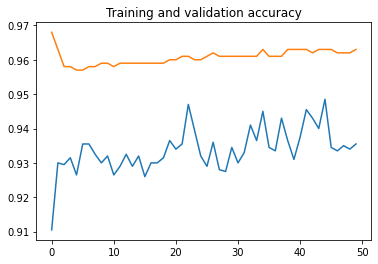

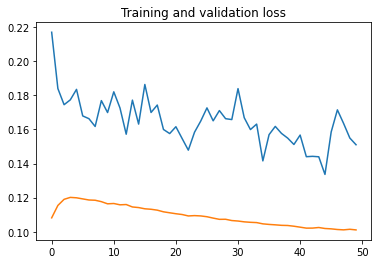

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Podemos extraer los valores de accuracy y loss del histórico que se ha guardado al entrenar la red
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Extraemos el número de épocas
epochs = range(len(acc))

# Representamos con plot nuestro accuracy por epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Representamos con plot nuestro loss por epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Enhroabuena! Mediante los modelos preentrenados y el fine-tuning has construido un modelo de clasificación de imagen que puede clasificar perros vs gatos con más del 90% de accuracy con tan sólo 2000 imágenes de entrenamiento!

## Clean Up

Antes de correr el siguiente ejercicio, corre la sigueinte celda para finalizar el kernel y liberar la memoria.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)